### Arrange Data

In [1]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_properties(filepath, sep='=', comment_char='#'):
    """
    Read the file passed as parameter as a properties file.
    """
    props = {}
    with open(filepath, "rt") as f:
        for line in f:
            l = line.strip()
            if l and not l.startswith(comment_char):
                key_value = l.split(sep)
                key = key_value[0].strip()
                value = sep.join(key_value[1:]).strip().strip('"') 
                props[key] = value 
    return props

In [3]:
connection = mysql.connector.connect(**load_properties('./project.properties'))

In [4]:
selected_region = 'RME'

In [5]:
query = "select * from weatherdailydelay_rainfallinranges where sbbregion_isocode = '" + selected_region + "'"

result = pd.read_sql(sql=query, con=connection)
result_df = pd.DataFrame(result)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
query

"select * from weatherdailydelay_rainfallinranges where sbbregion_isocode = 'RME'"

In [7]:
result_df.head()

,sbbregion_isocode,avg_delay,range,range_step
0,RME,8.015149,0.000000000000 mm - 6.602083332500 mm,6.602083
1,RME,10.913173,13.204166665000 mm - 19.806249997500 mm,6.602083
2,RME,12.629887,19.806249997500 mm - 26.408333330000 mm,6.602083
3,RME,10.503582,26.408333330000 mm - 33.010416662500 mm,6.602083
4,RME,10.198005,6.602083332500 mm - 13.204166665000 mm,6.602083


In [8]:
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

In [9]:
result_df['range_start'] = result_df['range'].str.split(" ", 1).str[0]

In [10]:
result_df.range_start = pd.to_numeric(result_df.range_start, errors='coerce')

In [11]:
result_df = result_df.sort_values('range_start')

In [12]:
text_array = [(str(round(value, 1)) + "% Verspätete Züge") for value in result_df['avg_delay'].to_numpy()]

In [13]:
result_df

,sbbregion_isocode,avg_delay,range,range_step,range_start
0,RME,8.015149,0.000000000000 mm - 6.602083332500 mm,6.602083,0.000000
4,RME,10.198005,6.602083332500 mm - 13.204166665000 mm,6.602083,6.602083
1,RME,10.913173,13.204166665000 mm - 19.806249997500 mm,6.602083,13.204167
2,RME,12.629887,19.806249997500 mm - 26.408333330000 mm,6.602083,19.806250
3,RME,10.503582,26.408333330000 mm - 33.010416662500 mm,6.602083,26.408333


In [14]:
avg_delay_region = {
  "RSD": 10.0,
  "RWT": 9.6,
  "ROT": 4.6,
  "RME": 9.3
}

### Lineplot

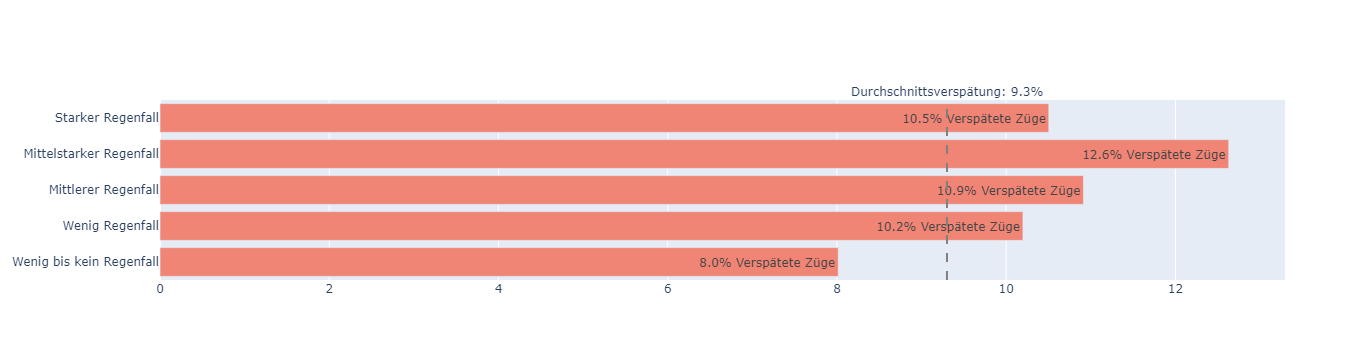

In [16]:
datatrace1 = {
    'name': 'Rainfall',
    'type': 'bar', 
    'y': result_df['range'], 
    'x': result_df['avg_delay'],
    'orientation': 'h',
    'text': text_array,
    'marker':{'color':'#f08576'}
}

figdict = {'data': [datatrace1]}

fig = go.Figure(**figdict)

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = result_df['range'],
        ticktext = ['Wenig bis kein Regenfall','Wenig Regenfall', 'Mittlerer Regenfall','Mittelstarker Regenfall','Starker Regenfall','']
    )
)

fig.add_vline(x=avg_delay_region.get(selected_region), annotation_xanchor='center', annotation_y=1.1, line_dash="dash", line_color="grey", annotation_text=f'Durchschnittsverspätung: {avg_delay_region.get(selected_region)}%')
fig.update_traces(textposition='auto')
fig.show()